In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chisquare

In [589]:
from scipy import stats
import seaborn as sns
import numpy as np

In [2]:
yellow_2018_06=pd.read_csv('yellow_tripdata_2018-06.csv',encoding='latin1')

In [3]:
taxi_zones=pd.read_csv('taxi_zone_lookup.csv',encoding='latin1')

In [4]:
yellow_tz_2018_06 = yellow_2018_06.merge(taxi_zones,left_on='PULocationID', right_on='LocationID')

In [5]:
#Creation of boroughs column (type Series)
boroughs=yellow_tz_2018_06['Borough']

In [6]:
#Creation of payment_type column (type Series)
payments_type=yellow_tz_2018_06['payment_type']

In [7]:
dict_pay_id={1:'Credit Card', 2:'Cash', 3:'No charge', 4:'Dispute', 5:'Unknown', 6:'Voided trip'}

In [13]:
# Merge the two Series in one dataframe:
df_201806=pd.concat([boroughs,payments_type], axis=1)

In [14]:
# We changed the id of the payments with the real, human readable, name 
# In the dataframe we are using => df_201806 

In [15]:
df_201806['payment_type']=df_201806['payment_type'].apply(lambda x: dict_pay_id[x])

In [16]:
# We need to see in which way are used means for each borough

In [18]:
def count_payments_per_borough(DF):
    d=dict()
    l=len(DF)
    
    for el in DF.iterrows():           #iterating rows through the dataframe
        if el[1][0] not in d.keys():   # if there still no Borough in the dict
            d[el[1][0]]=[[str(el[1][1]),1]]   # add Borough as key, setting the first list with the payment 
                                       # [payment_type, 1]     
        else:
            added=False
            lista=d[el[1][0]]
            for paymenttype_occurrences in lista:
                if paymenttype_occurrences[0] == str(el[1][1]):
                    paymenttype_occurrences[1]+=1
                    added=True
            if added==False:
                d[el[1][0]].append([el[1][1],1])                
           
    return d        

In [20]:
official_df_201806_dict_for_plot=count_payments_per_borough(df_201806)

In [22]:
def plot_dict(d):
    for key in d.keys():
        data_list=d[key]
        
        pay_types, values=zip(*data_list)
        
        fig, ax = plt.subplots(1)
        
        plt.bar(pay_types, values, color="orchid")
        ax.plot(pay_types,values, label=key)
        ax.set_title('%s' %key)
        
        plt.show()   

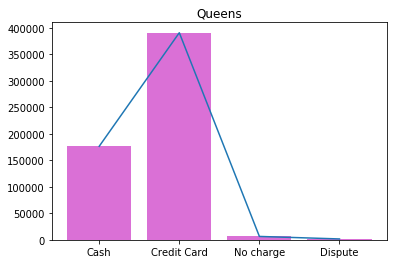

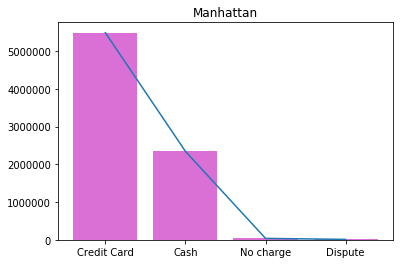

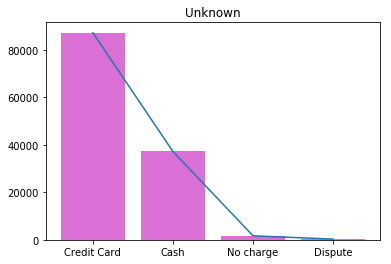

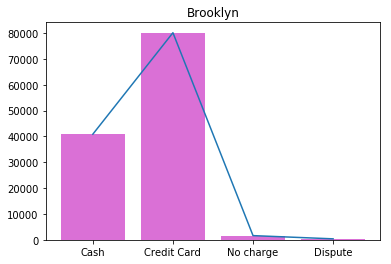

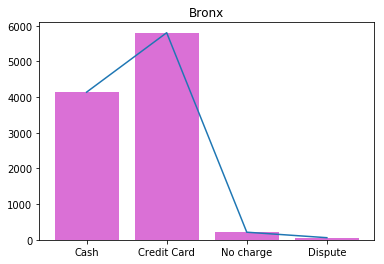

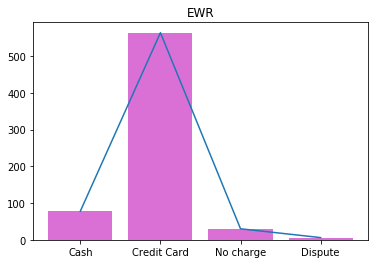

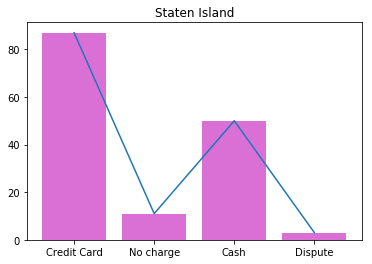

In [23]:
plot_dict(official_df_201806_dict_for_plot)

In [ ]:
#######################ChiSquared Test############################

In [53]:
# What we need to do it's to create a new dataframe basing on the dictionary we created and plotted.
# each column (Series) of the dataframe will be represented by borough and all types of payments.
# Chi square test:
# H_0  =  " the payment types are correlated to the borough "
# H_1  =  " the payment types are not correlated to the borough "

In [45]:
official_df_201806_dict_for_plot

{'Queens': [['Cash', 176317],
  ['Credit Card', 390484],
  ['No charge', 6338],
  ['Dispute', 1608]],
 'Manhattan': [['Credit Card', 5486670],
  ['Cash', 2343500],
  ['No charge', 37440],
  ['Dispute', 11199]],
 'Unknown': [['Credit Card', 87144],
  ['Cash', 37159],
  ['No charge', 1681],
  ['Dispute', 287]],
 'Brooklyn': [['Cash', 40856],
  ['Credit Card', 80116],
  ['No charge', 1619],
  ['Dispute', 370]],
 'Bronx': [['Cash', 4138],
  ['Credit Card', 5804],
  ['No charge', 213],
  ['Dispute', 59]],
 'EWR': [['Cash', 78],
  ['Credit Card', 564],
  ['No charge', 30],
  ['Dispute', 6]],
 'Staten Island': [['Credit Card', 87],
  ['No charge', 11],
  ['Cash', 50],
  ['Dispute', 3]]}

In [108]:
def create_df_b_pt(d):
    chi = {}
    #chi['Borough']=d.keys()
    #print(chi['Borough'])
    
    for e in d:
        for item in d[e]:
            if item[0] not in chi:
                chi[item[0]]=[item[1]]
            else:
                chi[item[0]].append(item[1])
    
    df=pd.DataFrame.from_dict(chi)
    df.loc[:,'Borough'] = pd.Series(list(d.keys()))
    return df   

In [109]:
del chi_df

In [302]:
chi_df = create_df_b_pt(official_df_201806_dict_for_plot)

In [469]:
chi_df

,Cash,Credit Card,No charge,Dispute,Borough
0,176317,390484,6338,1608,Queens
1,2343500,5486670,37440,11199,Manhattan
2,37159,87144,1681,287,Unknown
3,40856,80116,1619,370,Brooklyn
4,4138,5804,213,59,Bronx
5,78,564,30,6,EWR
6,50,87,11,3,Staten Island


In [586]:
def add_total_in_df(df):
    #first, deleting borough for make the sum without problem on string+int
    res_df= chi_df
    res_df=res_df.drop('Borough', 1)
    tot_columns=[]   #total per rows
    i=0
    r_df, c_df = res_df.shape
    while i<r_df:
        s = sum(res_df.iloc[i])
        i+=1
        tot_columns.append(s)
        
    i=0
    tot_rows=[] 
    s=0
    
    for pt in (res_df.columns).tolist():
        for element in res_df[str(pt)]:
            s += element
        tot_rows.append(s)
        s=0
    
    somma=sum(tot_rows)
    res_df.loc[7] = np.array(tot_rows)
    
    tot_columns.append(somma)
    res_df['Total'] = pd.Series(tot_columns)
    return res_df

In [580]:
aux_chi = add_total_in_df(chi_df)

In [495]:
#Assigns the frequency values
queens_count = aux_chi.iloc[0][0:5].values
manhattan_count = aux_chi.iloc[1][0:5].values
unknown_count = aux_chi.iloc[2][0:5].values
brooklyn_count = aux_chi.iloc[3][0:5].values
bronx_count = aux_chi.iloc[4][0:5].values
ewr_count = aux_chi.iloc[5][0:5].values
si_count = aux_chi.iloc[6][0:5].values

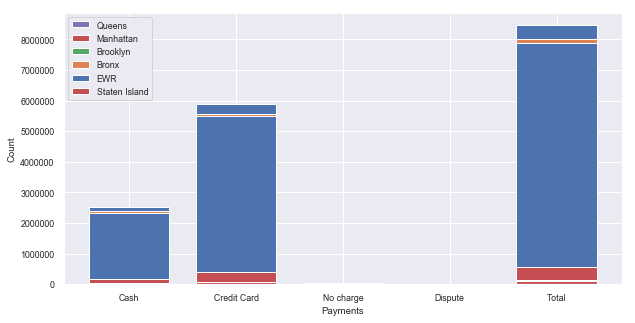

In [524]:
#Plots the bar chart
fig = plt.figure(figsize=(10, 5))
sns.set(font_scale=0.8)
categories = ['Cash', 'Credit Card', 'No charge', 'Dispute', 'Total']
p0 = plt.bar( categories, queens_count, 0.75, color='r')
p1 = plt.bar( categories, manhattan_count, 0.75, bottom = queens_count)
#p2 = plt.bar( categories, unknown_count, 0.75, bottom = manhattan_count)
p3 = plt.bar( categories, brooklyn_count, 0.75, bottom = manhattan_count)#bottom =unknown_count)
p4 = plt.bar( categories, bronx_count, 0.75, bottom = brooklyn_count)
p5 = plt.bar( categories, ewr_count, 0.75, bottom = bronx_count)
p6 = plt.bar( categories, si_count, 0.75, bottom = ewr_count)
# without p2[0] and ('Unknown'), because we don't know which quarter it is
plt.legend((p6[0], p5[0], p4[0], p3[0], p1[0], p0[0]), ('Queens', 'Manhattan', 'Brooklyn', 'Bronx', 'EWR','Staten Island'))
plt.xlabel('Payments')
plt.ylabel('Count')
plt.show()

In [555]:
args = (aux_chi.iloc[0][0:4].values, aux_chi.iloc[1][0:4].values, aux_chi.iloc[2][0:4].values,
                  aux_chi.iloc[3][0:4].values, aux_chi.iloc[4][0:4].values, aux_chi.iloc[5][0:4].values,
                  aux_chi.iloc[6][0:4].values )

In [579]:
aux_chi

,Cash,Credit Card,No charge,Dispute,Total
0,176317,390484,6338,1608,574747
1,2343500,5486670,37440,11199,7878809
2,37159,87144,1681,287,126271
3,40856,80116,1619,370,122961
4,4138,5804,213,59,10214
5,78,564,30,6,678
6,50,87,11,3,151
7,2602098,6050869,47332,13532,8713831


In [556]:
f_obs = np.concatenate(args)

In [557]:
f_obs

array([ 176317,  390484,    6338,    1608, 2343500, 5486670,   37440,
         11199,   37159,   87144,    1681,     287,   40856,   80116,
          1619,     370,    4138,    5804,     213,      59,      78,
           564,      30,       6,      50,      87,      11,       3],
      dtype=int64)

In [535]:
#Total number of paid trips for each borough
tot = aux_chi.loc[7]['Total']

In [563]:
row_sums = aux_chi.iloc[0:7,4].values

In [564]:
row_sums

array([ 574747, 7878809,  126271,  122961,   10214,     678,     151],
      dtype=int64)

In [565]:
col_sums = aux_chi.iloc[7,0:4].values

In [566]:
col_sums

array([2602098, 6050869,   47332,   13532], dtype=int64)

In [567]:
f_expected = []
for j in range(7):
    for i in col_sums:
        f_expected.append(i*row_sums[j]/tot)

In [568]:
f_expected

[171629.22016802942,
 399103.31117771275,
 3121.9247887639776,
 892.5438654938339,
 2352746.2422993975,
 5471031.184219777,
 42796.30711084482,
 12235.26636998124,
 37706.6661676133,
 87682.36146638602,
 685.8819010834615,
 196.09046491721034,
 36718.24392485923,
 85383.90325782081,
 667.902562259929,
 190.95025506003043,
 3050.0739539245137,
 7092.583728787028,
 55.48065460530506,
 15.861662683152794,
 202.462320419113,
 470.80201371819123,
 3.6827769553942464,
 1.0528889073015073,
 45.091165757059095,
 104.85413579859421,
 0.8202054871158277,
 0.23449295723086666]

In [569]:
chi_squared_statistic = ((f_obs - f_expected)**2/f_expected).sum()
print('Chi-squared Statistic: {}'.format(chi_squared_statistic))

Chi-squared Statistic: 10506.196909036636


In [570]:
#Degree of Freedom
dof = (len(row_sums)-1)*(len(col_sums)-1)
print("Degrees of Freedom: {}".format(dof))

Degrees of Freedom: 18


In [584]:
f_obs_i = np.array(args)     #indipendent

In [582]:
# Chi square for indipendence
from scipy import stats
stats.chi2_contingency(f_obs_i)

(10506.196909036636,
 0.0,
 18,
 array([[1.71629220e+05, 3.99103311e+05, 3.12192479e+03, 8.92543865e+02],
        [2.35274624e+06, 5.47103118e+06, 4.27963071e+04, 1.22352664e+04],
        [3.77066662e+04, 8.76823615e+04, 6.85881901e+02, 1.96090465e+02],
        [3.67182439e+04, 8.53839033e+04, 6.67902562e+02, 1.90950255e+02],
        [3.05007395e+03, 7.09258373e+03, 5.54806546e+01, 1.58616627e+01],
        [2.02462320e+02, 4.70802014e+02, 3.68277696e+00, 1.05288891e+00],
        [4.50911658e+01, 1.04854136e+02, 8.20205487e-01, 2.34492957e-01]]))

In [588]:
# p-value = 0 : we understood that there is no correlation between the borough and the payment method

In [590]:
del yellow_2018_06
del taxi_zones
del yellow_tz_2018_06
del df_201806
del official_df_201806_dict_for_plot